# Separating Gamma from Hadron at Gamma Telescope

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

import joblib

In [2]:
names = ['flength', 'fwidth', 'fsize', 'fconc', 'fconcl', 'fasym', 'fm3long', 'fm3trans', 'falpha', 'fdist', 'class']
magic = pd.read_csv('magic04.data', header = None, names = names)
print(magic.shape)
magic.head(2)

(19020, 11)


,flength,fwidth,fsize,fconc,fconcl,fasym,fm3long,fm3trans,falpha,fdist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g


In [3]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(magic)

flength 
 [  4.2835   7.2079   7.3606 ... 305.422  310.61   334.177 ] 

fwidth 
 [0.000000e+00 1.000000e-04 2.000000e-04 ... 2.205144e+02 2.280385e+02
 2.563820e+02] 

fsize 
 [1.9413 1.9468 1.9916 ... 5.1467 5.1795 5.3233] 

fconc 
 [0.0131 0.0133 0.0137 ... 0.8889 0.8912 0.893 ] 

fconcl 
 [3.000e-04 8.000e-04 1.100e-03 ... 6.430e-01 6.740e-01 6.752e-01] 

fasym 
 [-457.9161 -449.9526 -382.594  ...  464.631   473.0654  575.2407] 

fm3long 
 [-331.78   -318.3002 -297.1717 ...  227.8174  231.446   238.321 ] 

fm3trans 
 [-205.8947 -164.14   -149.5513 ...  163.2697  170.692   179.851 ] 

falpha 
 [0.00000e+00 2.00000e-04 3.00000e-04 ... 8.99579e+01 8.99798e+01
 9.00000e+01] 

fdist 
 [  1.2826   5.5449   5.5922 ... 450.953  466.4078 495.561 ] 

class 
 ['g' 'h'] 



In [4]:
def snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

snapshot = snapshot(magic)
snapshot

,n_unique,dtype,n_missing,pct_missing
flength,18643,float64,0,0.0
fwidth,18200,float64,0,0.0
fsize,7228,float64,0,0.0
fconc,6410,float64,0,0.0
fconcl,4421,float64,0,0.0
fasym,18704,float64,0,0.0
fm3long,18693,float64,0,0.0
fm3trans,18390,float64,0,0.0
falpha,17981,float64,0,0.0
fdist,18437,float64,0,0.0


In [5]:
numer = magic.columns.drop('class')

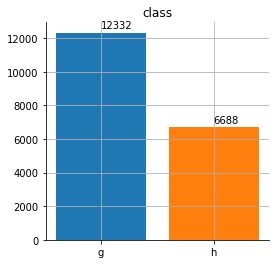

In [6]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()
    
plot_single_categorical(magic, 'class')

In [8]:
def scatter_features_correlation(df, features, target):
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()

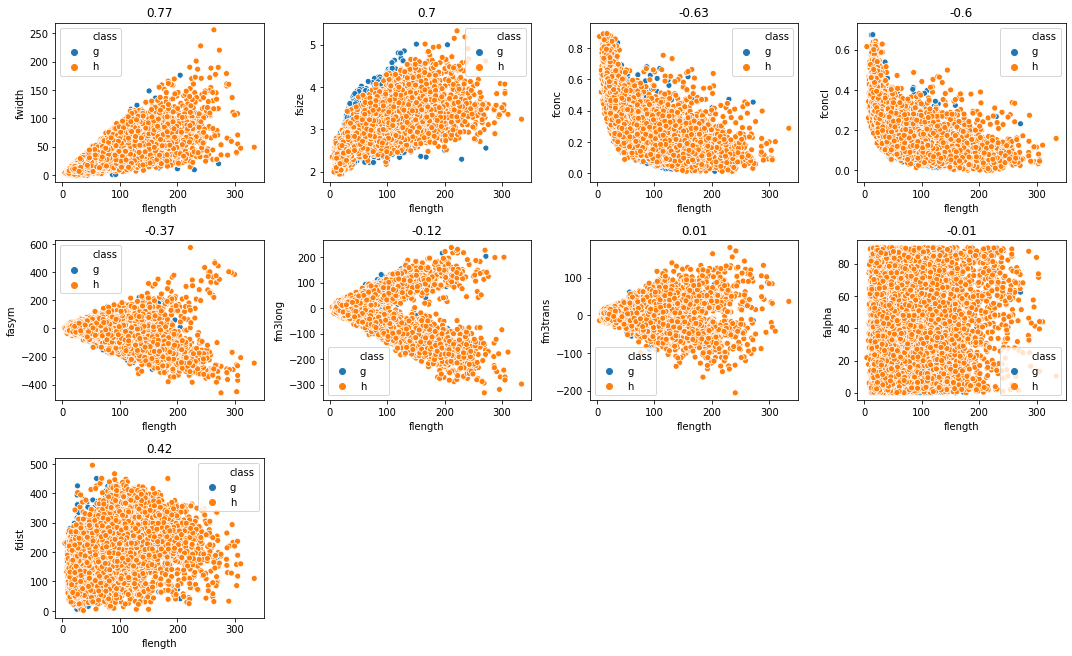

In [9]:
scatter_features_correlation(magic, numer.tolist(), 'class')

In [15]:
enc = LabelEncoder()
y = enc.fit_transform(magic['class'])

In [17]:
def feat_significance(X, y, n_feat_data_type, num):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in num:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [22]:
feat_score = feat_significance(magic[numer], y, 1, '')
feat_score

,score
falpha,0.124170
fwidth,0.096833
flength,0.085570
fm3long,0.077693
fm3trans,0.068657
fsize,0.052868
fasym,0.043405
fconc,0.023764
fdist,0.013386
fconcl,0.013302


In [20]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [21]:
get_mean_std(magic[numer])

,mean,std
flength,53.250154,42.364855
fwidth,22.180966,18.346056
fsize,2.825017,0.472599
fconc,0.380327,0.182813
fconcl,0.214657,0.110511
fasym,-4.331745,59.206062
fm3long,10.545545,51.000118
fm3trans,0.249726,20.827439
falpha,27.645707,26.103621
fdist,193.818026,74.731787


In [26]:
X_scaled = pd.DataFrame(scale(magic[feat_score.index]), columns = feat_score.index)

In [27]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)

In [28]:
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [29]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

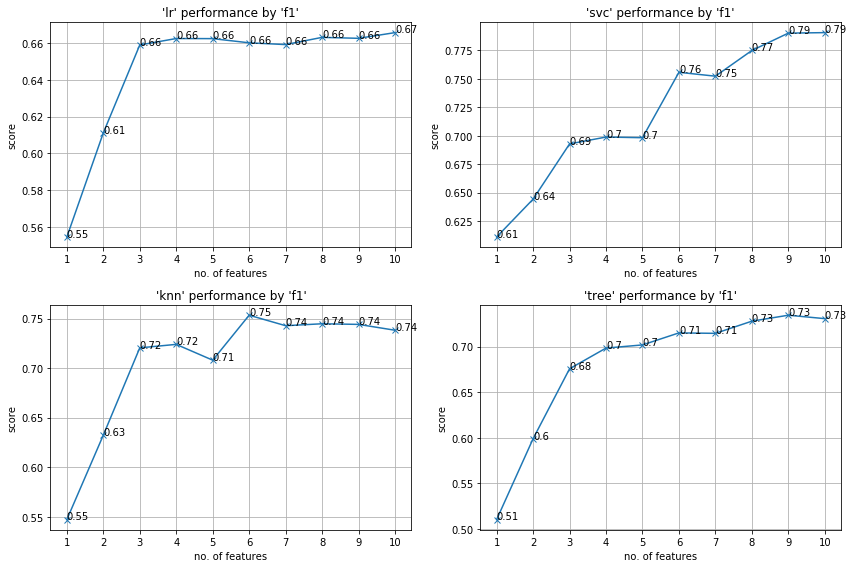

In [30]:
num_feat_multi_alg(alg_dict, feat_score.index, X_scaled, y, 'f1')

In [41]:
feat_7 = feat_score.index.drop([feat_score.index[4], feat_score.index[6], feat_score.index[9]])

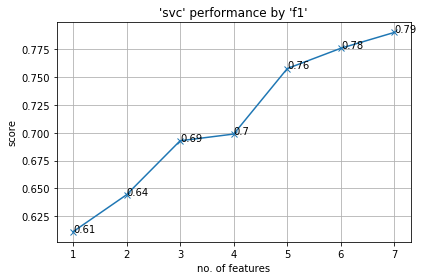

In [42]:
num_feat_multi_alg({svc: 'svc'}, feat_7, X_scaled[feat_7], y, 'f1')

In [59]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 10, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

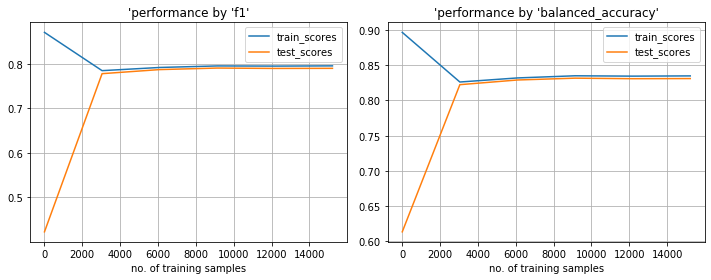

In [60]:
two_metric_graph(svc, X_scaled[feat_7], y)

In [61]:
svc.fit(X_scaled[feat_7], y)
joblib.dump(svc, 'svc.joblib')

['svc.joblib']